In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import sem, t
from sklearn.utils import resample
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer

In [54]:
data_path = '/content/drive/MyDrive/520/Rest_Graphql.csv'
data = pd.read_csv(data_path)

In [55]:
data.head()

,Label,group,# Samples,Average,Min,Max,Std. Dev.,Error %,Throughput,Received KB/sec,Sent KB/sec,Avg. Bytes,Api_No,Category,Api
0,Rest,1,1,673,673,673,0.0,0.00%,1.48588,1.39,0.42,961.0,1,Animal,http://dog-api.kinduff.com/api/facts?number=5
1,Rest,1,1,320,320,320,0.0,0.00%,3.12500,11.02,0.80,3610.0,2,Animal,https://dog.ceo/api/breeds/list/all
2,Rest,1,1,150,150,150,0.0,0.00%,6.66667,134.75,1.60,20697.0,3,Animal,https://http.cat/status/200
3,Rest,1,1,74,74,74,0.0,0.00%,13.51351,27.49,1.79,2083.0,4,Animal,https://meowfacts.herokuapp.com/?count=3
4,Rest,1,1,367,367,367,0.0,0.00%,2.72480,46.62,0.67,17521.0,5,Animal,https://placebear.com/g/200/300


In [56]:
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Label            1500 non-null   object 
 1   group            1500 non-null   int64  
 2   # Samples        1500 non-null   int64  
 3   Average          1500 non-null   int64  
 4   Min              1500 non-null   int64  
 5   Max              1500 non-null   int64  
 6   Std. Dev.        1500 non-null   float64
 7   Error %          1500 non-null   object 
 8   Throughput       1500 non-null   float64
 9   Received KB/sec  1500 non-null   float64
 10  Sent KB/sec      1500 non-null   float64
 11  Avg. Bytes       1500 non-null   float64
 12  Api_No           1500 non-null   int64  
 13  Category         1495 non-null   object 
 14  Api              1500 non-null   object 
dtypes: float64(5), int64(6), object(4)
memory usage: 175.9+ KB


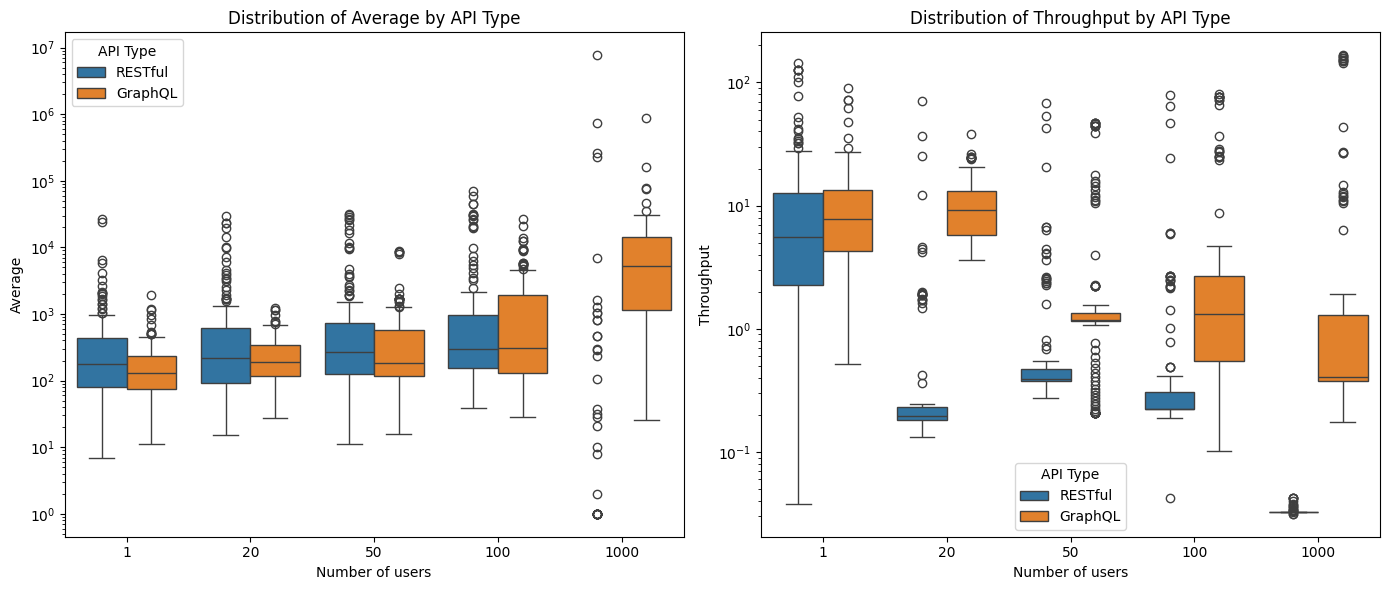

In [57]:
rest_apis = data[data['group'] == 1]
graphql_apis = data[data['group'] == 2]

# Functions to calculate confidence intervals
def bootstrap_confidence_interval(data, n_bootstraps=1000, ci=95):
    """Calculate confidence interval for a sample data using bootstrap."""
    bootstrap_samples = np.array([resample(data) for _ in range(n_bootstraps)])
    bootstrap_means = np.mean(bootstrap_samples, axis=1)
    lower_bound = np.percentile(bootstrap_means, (100 - ci) / 2)
    upper_bound = np.percentile(bootstrap_means, 100 - (100 - ci) / 2)
    return np.mean(data), lower_bound, upper_bound

# Calculate confidence intervals for Average and Throughput
rest_conf_intervals = rest_apis.groupby('# Samples')['Average'].apply(bootstrap_confidence_interval)
graphql_conf_intervals = graphql_apis.groupby('# Samples')['Average'].apply(bootstrap_confidence_interval)
rest_throughput_conf_intervals = rest_apis.groupby('# Samples')['Throughput'].apply(bootstrap_confidence_interval)
graphql_throughput_conf_intervals = graphql_apis.groupby('# Samples')['Throughput'].apply(bootstrap_confidence_interval)

# Prepare plotting data
metrics = ['Average', 'Throughput']
data_for_plot = pd.concat([
    rest_apis.assign(API_Type='RESTful')[['# Samples', 'API_Type'] + metrics],
    graphql_apis.assign(API_Type='GraphQL')[['# Samples', 'API_Type'] + metrics]
])

# Plotting box lines
plt.figure(figsize=(14, 6))
for i, metric in enumerate(metrics, 1):
    plt.subplot(1, 2, i)
    sns.boxplot(data=data_for_plot, x='# Samples', y=metric, hue='API_Type')
    plt.title(f'Distribution of {metric} by API Type')
    plt.xlabel('Number of users')
    plt.ylabel(metric)
    plt.yscale('log')  # Set logarithmic scales for both plots
    plt.legend(title='API Type')

plt.tight_layout()
plt.show()



In [58]:
# Calculate percentile
percentiles = [90, 95, 99]
rest_percentiles = np.percentile(rest_apis['Average'], percentiles)
graphql_percentiles = np.percentile(graphql_apis['Average'], percentiles)

print("RESTful API Percentiles (90%, 95%, 99%):", rest_percentiles)
print("GraphQL API Percentiles (90%, 95%, 99%):", graphql_percentiles)

RESTful API Percentiles (90%, 95%, 99%): [ 2049.    9659.55 38182.39]
GraphQL API Percentiles (90%, 95%, 99%): [ 8676.7  14507.65 29074.15]


In [59]:
# Statistical significance tests
u_stat, p_value = stats.mannwhitneyu(rest_apis['Average'], graphql_apis['Average'])
print("Mann-Whitney U test p-value:", p_value)

Mann-Whitney U test p-value: 4.6286897552229145e-12


In [60]:
rest_throughput_mean = rest_apis['Throughput'].mean()
graphql_throughput_mean = graphql_apis['Throughput'].mean()

# Mann-Whitney U test comparing throughput rates
u_stat_throughput, p_value_throughput = stats.mannwhitneyu(rest_apis['Throughput'], graphql_apis['Throughput'])

print("RESTful API Average Throughput:", rest_throughput_mean)
print("GraphQL API Average Throughput:", graphql_throughput_mean)
print("Mann-Whitney U test p-value:", p_value_throughput)

RESTful API Average Throughput: 4.017793093333333
GraphQL API Average Throughput: 9.536951626666667
Mann-Whitney U test p-value: 3.810719516233757e-83


In [61]:
# Average of error rates
rest_error_rate_mean = rest_apis['Error %'].replace('%', '', regex=True).astype(float).mean()
graphql_error_rate_mean = graphql_apis['Error %'].replace('%', '', regex=True).astype(float).mean()

# Mann-Whitney U test comparing error rates
u_stat_error, p_value_error = stats.mannwhitneyu(
    rest_apis['Error %'].replace('%', '', regex=True).astype(float),
    graphql_apis['Error %'].replace('%', '', regex=True).astype(float)
)

print("RESTful API Average Error Rate:", rest_error_rate_mean)
print("GraphQL API Average Error Rate:", graphql_error_rate_mean)
print("Mann-Whitney U test p-value:", p_value_error)

RESTful API Average Error Rate: 22.784319999999997
GraphQL API Average Error Rate: 19.73312
Mann-Whitney U test p-value: 0.12107101050919478


In [62]:
# Calculate average receive and transmit KB/sec
rest_received_mean = rest_apis['Received KB/sec'].mean()
graphql_received_mean = graphql_apis['Received KB/sec'].mean()
rest_sent_mean = rest_apis['Sent KB/sec'].mean()
graphql_sent_mean = graphql_apis['Sent KB/sec'].mean()

# Mann-Whitney U test comparing data reception and transmission efficiency
u_stat_received, p_value_received = stats.mannwhitneyu(rest_apis['Received KB/sec'], graphql_apis['Received KB/sec'])
u_stat_sent, p_value_sent = stats.mannwhitneyu(rest_apis['Sent KB/sec'], graphql_apis['Sent KB/sec'])

print("RESTful API Average Received KB/sec:", rest_received_mean)
print("GraphQL API Average Received KB/sec:", graphql_received_mean)
print("RESTful API Average Sent KB/sec:", rest_sent_mean)
print("GraphQL API Average Sent KB/sec:", graphql_sent_mean)
print("Received Data Mann-Whitney U test p-value:", p_value_received)
print("Sent Data Mann-Whitney U test p-value:", p_value_sent)

RESTful API Average Received KB/sec: 90.42678666666666
GraphQL API Average Received KB/sec: 190.36276
RESTful API Average Sent KB/sec: 0.6464666666666666
GraphQL API Average Sent KB/sec: 5.53832
Received Data Mann-Whitney U test p-value: 5.409561089005757e-40
Sent Data Mann-Whitney U test p-value: 3.0834416139966266e-101


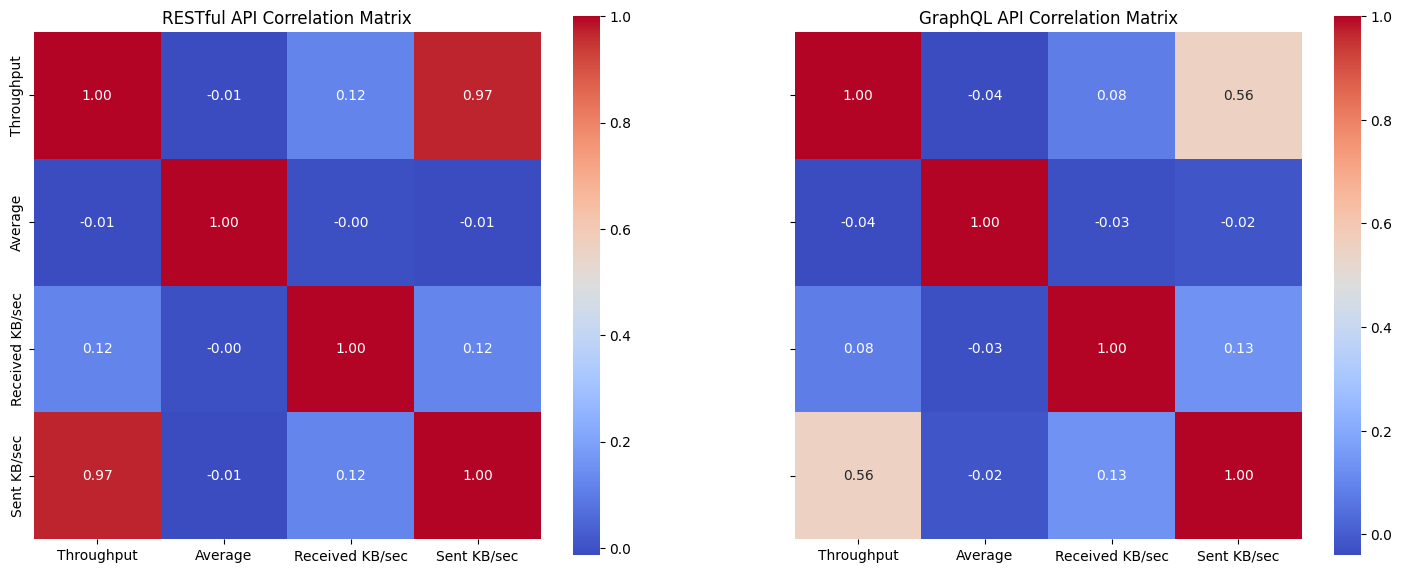

In [63]:
# Calculate the correlation matrix for the selected metrics for RESTful and GraphQL APIs
selected_metrics = ['Throughput', 'Average', 'Received KB/sec', 'Sent KB/sec']
rest_corr = rest_apis[selected_metrics].corr()
graphql_corr = graphql_apis[selected_metrics].corr()

# Plotting the correlation matrix using a heatmap for a direct visual comparison

# Set up the matplotlib figure
fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

# Draw the heatmaps
sns.heatmap(rest_corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, ax=axes[0])
axes[0].set_title('RESTful API Correlation Matrix')

sns.heatmap(graphql_corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, ax=axes[1])
axes[1].set_title('GraphQL API Correlation Matrix')

plt.show()

<Figure size 1000x600 with 0 Axes>

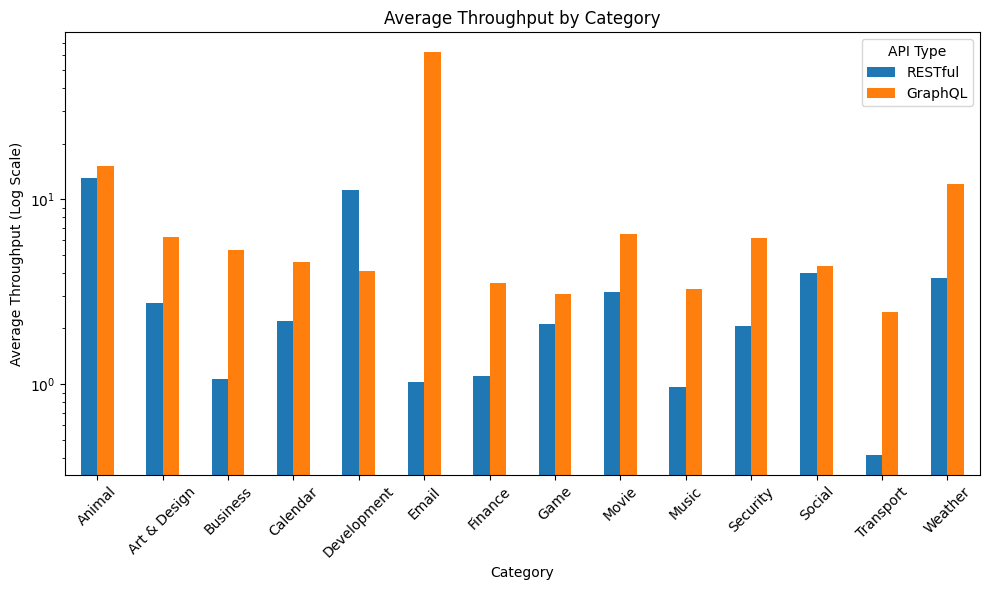

In [64]:
category_throughput = data.groupby(['Category', 'group'])['Throughput'].mean().unstack()

# Plot a bar chart showing the average throughput of RESTful and GraphQL APIs
plt.figure(figsize=(10, 6))
category_throughput.plot(kind='bar', logy=True, figsize=(10, 6))
plt.title('Average Throughput by Category')
plt.ylabel('Average Throughput (Log Scale)')
plt.xlabel('Category')
plt.legend(['RESTful', 'GraphQL'], title="API Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

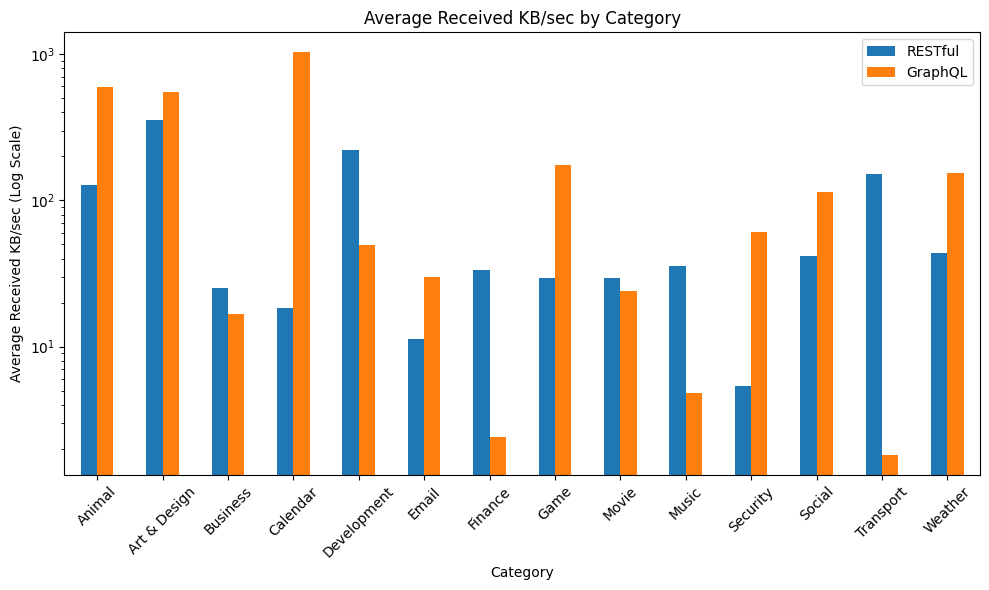

In [65]:
# Plotting the average received KB/sec by category for RESTful and GraphQL APIs using a log scale
plt.figure(figsize=(10, 6))
category_received_kbsec = data.groupby(['Category', 'group'])['Received KB/sec'].mean().unstack()
category_received_kbsec.plot(kind='bar', logy=True, figsize=(10, 6))
plt.title('Average Received KB/sec by Category')
plt.ylabel('Average Received KB/sec (Log Scale)')
plt.xlabel('Category')
plt.legend(['RESTful', 'GraphQL'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



<Figure size 1000x600 with 0 Axes>

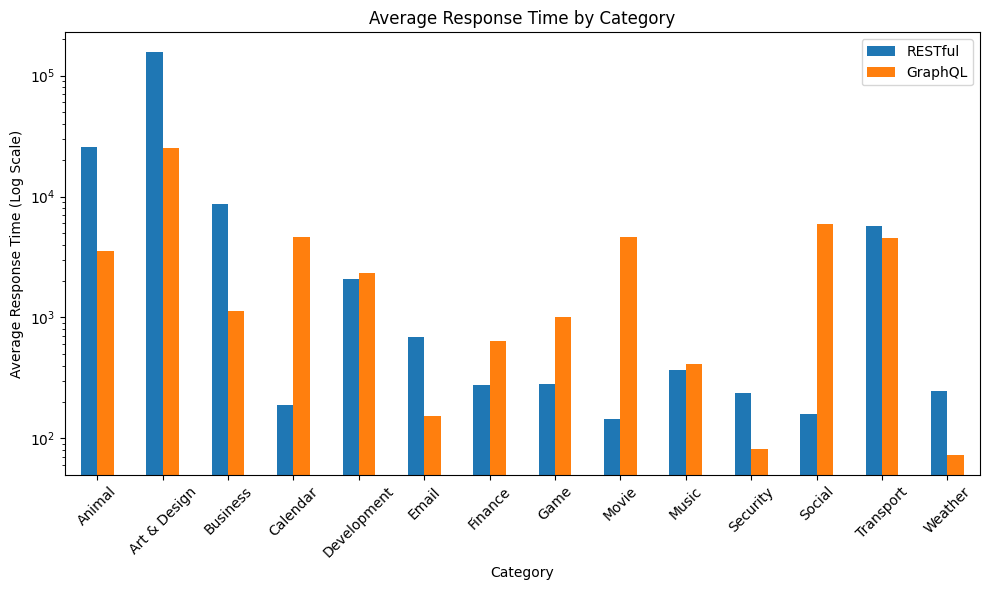

In [66]:
# We will recreate a similar plot to the one provided by the user using the loaded data
# First, we need to prepare the data accordingly

# Calculate the average response time by category and API group
category_response_time = data.groupby(['Category', 'group'])['Average'].mean().unstack()

# Plotting the average response time by category for RESTful and GraphQL APIs using a log scale
plt.figure(figsize=(10, 6))
category_response_time.plot(kind='bar', logy=True, figsize=(10, 6))
plt.title('Average Response Time by Category')
plt.ylabel('Average Response Time (Log Scale)')
plt.xlabel('Category')
plt.legend(['RESTful', 'GraphQL'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [67]:
# Data cleaning
data['Error %'] = data['Error %'].str.rstrip('%').astype('float') / 100.0
data['Category'].fillna("Unknown", inplace=True)

scaler = MinMaxScaler()
data_scaled = data.copy()
columns_to_scale = ['Average', 'Throughput', 'Std. Dev.', 'Error %', 'Received KB/sec', 'Sent KB/sec']
data_scaled[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

# Characterization and selection of target variables
features = data_scaled[['Average', 'Std. Dev.', 'Error %', 'Received KB/sec', 'Sent KB/sec']]
target = data_scaled['Throughput']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Define the random forest model
rf = RandomForestRegressor(random_state=42)

# Parametric grids
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Setting up grid searches
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
# Fitting grid searches
grid_search.fit(X_train, y_train)

# Optimal parameters and scoring
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", -grid_search.best_score_)



Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best score found:  0.001240998015821025


In [68]:
# 使用最佳参数的模型进行预测
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Test Mean Squared Error: ", mse)

# 获取特征重要性
feature_importances = best_rf.feature_importances_
print("Feature Importances:", feature_importances)

Test Mean Squared Error:  0.0007211036635040956
Feature Importances: [0.13940069 0.02394004 0.07064666 0.09441094 0.67160167]


In [69]:
def recommend_api(data_scaled, category, user_num):
    filtered_data = data_scaled[data_scaled['Category'].str.lower() == category.lower()]
    if filtered_data.empty:
        return "not found for the specified category。"

    # Calculate adjusted score using weights obtained from machine learning
    filtered_data['Adjusted Score'] = (
        -1.0 * filtered_data['Average'] * 0.4022 +
        -1.0 * filtered_data['Std. Dev.'] * 0.014 +
        -1.0 * filtered_data['Error %'] * 0.0015 +
        filtered_data['Received KB/sec'] * 0.0271 +
        filtered_data['Sent KB/sec'] * 0.5551
    )

    closest_user_num = filtered_data.iloc[(filtered_data['# Samples'] - user_num).abs().argsort()[:1]]
    top_api = closest_user_num.sort_values(by='Adjusted Score', ascending=False).iloc[0]
    return {
        'API Label': top_api['Label'],
        'API Group': 'RESTful' if top_api['group'] == 1 else 'GraphQL',
        'API Number': top_api['Api_No'],
        'Recommended for User Number': top_api['# Samples'],
        'Adjusted Score': top_api['Adjusted Score']
    }

In [70]:
def main():
    # Extract and sort unique categories from data
    unique_categories = sorted(data['Category'].unique())
    categories_str = ', '.join(unique_categories)  # Convert categories to strings for display

    # Input prompts, including all available categories
    print("Please enter your API category (Available categories: {})".format(categories_str))
    category = input()

    # of users entered
    user_num = int(input("Please enter your target number of users: "))

    # Get recommended APIs
    result = recommend_api(data_scaled, category, user_num)

    # Output recommended API details
    print("\nRecommended API details are as follows:")
    for key, value in result.items():
        print(f"{key}: {value}")

if __name__ == "__main__":
    main()

Please enter your API category (Available categories: Animal, Art & Design, Business, Calendar, Development, Email, Finance, Game, Movie, Music, Security, Social, Transport, Unknown, Weather)
Email
Please enter your target number of users: 45

Recommended API details are as follows:
API Label: Rest
API Group: RESTful
API Number: 61
Recommended for User Number: 50
Adjusted Score: 8.534368611566682e-05


<ipython-input-69-db0c86c8bc8b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Adjusted Score'] = (
